# Lab 7a - Patrick Farnole

In [18]:
import context
from IPython.display import Image
import IPython.display as display
# import plotting package and numerical python package for use in examples later
import matplotlib.pyplot as plt
# make the plots happen inline
%matplotlib inline  
# import the numpy array handling library
import numpy as np
# import the quiz script
from numlabs.lab7 import quiz7 as quiz
# import the pde solver for a simple 1-d tank of water with a drop of rain
from numlabs.lab7 import rain, rainlab
# import the dispersion code plotter
from numlabs.lab7 import accuracy2d
# import the 2-dimensional drop solver
from numlabs.lab7 import interactive1
# import the 2-dimensional dispersion relation plotter
from numlabs.lab7 import dispersion_2d

## modified rain.py

NOTE: Including in the below cell the modified code for rain.py. It needs to be inserted in the right directory and named "rainlab.py" to work (see below imports).

In [ ]:
#!/usr/bin/env python
"""Calculate the values of surface height (h) and east-west velocity
(u) in a dish of water where a point disturbance of h initiates waves.
Use the simplified shallow water equations on a non-staggered grid.

This is an implementation of lab7 section 4.3.

Example usage from the notebook::

from numlabs.lab7 import rain
# Run 5 time steps on a 9 point grid
rain.rain(5,9)

Example usage from the shell::

  # Run 5 time steps on a 9 point grid
  $ rain.py 5 9

The graph window will close as soon as the animation finishes.  And
the default run for 5 time steps doesn't produce much of interest; try
at least 100 steps.

Example usage from the Python interpreter::

  $ python
  ...
  >>> import rain
  >>> # Run 200 time steps on a 9 point grid
  >>> rain.rain((200, 9))
"""
from __future__ import division
import copy
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.colorbar as colorbar
import os,glob

class Quantity(object):
    """Generic quantity to define the data structures and method that
    are used for both u and h.

    u and h objects will be instances of this class.
    """
    def __init__(self, n_grid, n_time):
        """Initialize an object with prev, now, and next arrays of
        n_grid points, and a store array of n_time time steps.
        """
        self.n_grid = n_grid
        # Storage for values at previous, current, and next time step
        self.prev = np.empty(n_grid)
        self.now = np.empty(n_grid)
        self.next = np.empty(n_grid)
        # Storage for results at each time step.  In a bigger model
        # the time step results would be written to disk and read back
        # later for post-processing (such as plotting).
        self.store = np.empty((n_grid, n_time))


    def store_timestep(self, time_step, attr='next'):
        """Copy the values for the specified time step to the storage
        array.

        The `attr` argument is the name of the attribute array (prev,
        now, or next) that we are going to store.  Assigning the value
        'next' to it in the function def statement makes that the
        default, chosen because that is the most common use (in the
        time step loop).
        """
        # The __getattribute__ method let us access the attribute
        # using its name in string form;
        # i.e. x.__getattribute__('foo') is the same as x.foo, but the
        # former lets us change the name of the attribute to operate
        # on at runtime.
        self.store[:, time_step] = self.__getattribute__(attr)


    def shift(self):
        """Copy the .now values to .prev, and the .next values to .new.

        This reduces the storage requirements of the model to 3 n_grid
        long arrays for each quantity, which becomes important as the
        domain size and model complexity increase.  It is possible to
        reduce the storage required to 2 arrays per quantity.
        """
        # Note the use of the copy() method from the copy module in
        # the standard library here to get a copy of the array, not a
        # copy of the reference to it.  This is an important and
        # subtle aspect of the Python data model.
        self.prev = copy.copy(self.now)
        self.now = copy.copy(self.next)


def initial_conditions(u, v, h, ho):
    """Set the initial condition values.
    """
    u.prev[:] = 0
    v.prev[:] = 0
    h.prev[:] = 0
    h.prev[len(h.prev) // 2] = ho


def boundary_conditions(u_array, v_array, h_array, n_grid): # pf_add "v_array"
    """Set the boundary condition values.
    """
    u_array[0] = 0
    u_array[n_grid - 1] = 0
    v_array[0] = 0 # pf_add. Remark: could be another value but we don't care about the second spatial dimension, so 0 is fine
    v_array[n_grid - 1] = 0 # pf_add - same remark
    h_array[0] = h_array[1]
    h_array[n_grid-1] = h_array[n_grid-2]


def first_time_step(u, v, h, g, H, dt, dx, ho, gu, gh, n_grid):  # pf_add "v"
    """Calculate the first time step values from the analytical
    predictor-corrector derived from equations 4.18 and 4.19.
    """
    u.now[1:n_grid - 1] = 0
    v.now[1:n_grid - 1] = 0 # pf_add
    factor = gu * ho / 2
    midpoint = n_grid // 2
    u.now[midpoint - 1] = -factor
    u.now[midpoint] = factor
    v.now[midpoint - 1] = 0 # pf_add
    v.now[midpoint] = 0 # pf_add
    h.now[1:n_grid - 1] = 0
    h.now[midpoint] = ho # - g * H * ho * dt ** 2 / (4 * dx ** 2)


def leap_frog(u, v, h, gu, gv, gh, n_grid): # pf_add "v, gv"
    """Calculate the next time step values using the leap-frog scheme
    derived from equations 4.16 and 4.17.
    """
    for pt in np.arange(1, n_grid - 1):
        u.next[pt] = u.prev[pt] - gu * (h.now[pt + 1] - h.now[pt]) + gv * v.now[pt] # [pt-1] --> [pt]
        v.next[pt] = v.prev[pt] + gv * u.now[pt] # pf_add
        h.next[pt] = h.prev[pt] - gh * (u.now[pt] - u.now[pt - 1]) # [pt+1] --> [pt] 
#     Alternate vectorized implementation:
#     u.next[1:n_grid - 1] = (u.prev[1:n_grid - 1]
#                             - gu * (h.now[2:n_grid] - h.now[:n_grid - 2]))
#     h.next[1:n_grid - 1] = (h.prev[1:n_grid - 1]
#                             - gh * (u.now[2:n_grid] - u.now[:n_grid - 2]))


def make_graph(u, v, h, dt, n_time):
    """Create graphs of the model results using matplotlib.

    You probably need to run the rain script from within ipython,
    in order to see the graphs.  And
    the default run for 5 time steps doesn't produce much of interest;
    try at least 100 steps.
    """

    # Create a figure with 2 sub-plots
    fig, (ax_u, ax_v, ax_h) = plt.subplots(3,1, figsize=(15,12))

    # Set the figure title, and the axes labels.
    the_title = fig.text(0.25, 0.95, 'Results from t = %.3fs to %.3fs' % (0, dt*n_time))
    ax_u.set_ylabel('u [cm/s]')
    ax_v.set_ylabel('v [cm/s]')
    ax_h.set_ylabel('h [cm]')
    ax_h.set_xlabel('Grid Point')

    # We use color to differentiate lines at different times.  Set up the color map
    cmap = plt.get_cmap('viridis')
    cNorm  = colors.Normalize(vmin=0, vmax=1.*n_time)
    cNorm_inseconds = colors.Normalize(vmin=0, vmax=1.*n_time*dt)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)

    # Only try to plot 20 lines, so choose an interval if more than that (i.e. plot
    # every interval lines
    interval = np.int(np.ceil(n_time/20))

    # Do the main plot
    for time in range(0, n_time, interval):
        colorVal = scalarMap.to_rgba(time)
        ax_u.plot(u.store[:, time], color=colorVal)
        ax_v.plot(v.store[:, time], color=colorVal)
        ax_h.plot(h.store[:, time], color=colorVal)

    # Add the custom colorbar
    ax2 = fig.add_axes([0.95, 0.05, 0.05, 0.9])
    cb1 = colorbar.ColorbarBase(ax2, cmap=cmap, norm=cNorm_inseconds)
    cb1.set_label('Time (s)')
    return

def rain(args):
    """Run the model.

    args is a 2-tuple; (number-of-time-steps, number-of-grid-points)
    """
    n_time = int(args[0])
    n_grid = int(args[1])
#     Alternate implementation:
#     n_time, n_grid = map(int, args)

    # Constants and parameters of the model
    g = 980                     # acceleration due to gravity [cm/s^2]
    H = 1                       # water depth [cm]
    dt = 0.001                  # time step [s]
    dx = 1                      # grid spacing [cm]
    ho = 0.01                   # initial perturbation of surface [cm]
    f = 0.000145                # Coriolis frequency [s^-1]
    gu = 2 * g * dt / dx        # first handy constant
    gv = 2 * f * dt             # third handy constant
    gh = H * dt / dx            # second handy constant
    # Create velocity and surface height objects
    u = Quantity(n_grid, n_time)
    v = Quantity(n_grid, n_time) # pf_add
    h = Quantity(n_grid, n_time)
    # Set up initial conditions and store them in the time step
    # results arrays
    initial_conditions(u, v, h, ho)  # pf_add # pf_note > edit initial_conditions
    u.store_timestep(0, 'prev')
    v.store_timestep(0, 'prev') # pf_add
    h.store_timestep(0, 'prev')
    # Calculate the first time step values from the
    # predictor-corrector, apply the boundary conditions, and store
    # the values in the time step results arrays
    first_time_step(u, v, h, g, H, dt, dx, ho, gu, gh, n_grid)  # pf_add # pf_note > edit first_time_step
    boundary_conditions(u.now, v.now, h.now, n_grid)  # pf_add # pf_note > edit boundary_conditions
    u.store_timestep(1, 'now')
    v.store_timestep(1, 'now') # pf_add
    h.store_timestep(1, 'now')
    # Time step loop using leap-frog scheme
    for t in np.arange(2, n_time):
        # Advance the solution and apply the boundary conditions
        leap_frog(u, v, h, gu, gv, gh, n_grid) # pf_add # pf_note > edit leap_frog
        boundary_conditions(u.next, v.next, h.next, n_grid)
        # Store the values in the time step results arrays, and shift
        # .now to .prev, and .next to .now in preparation for the next
        # time step
        u.store_timestep(t)
        v.store_timestep(t) # pf_add
        h.store_timestep(t)
        u.shift()
        v.shift() # pf_add
        h.shift()

    # Plot the results as colored graphs
    make_graph(u, v, h, dt, n_time)
    return


if __name__ == '__main__':
    # sys.argv is the command-line arguments as a list. It includes
    # the script name as its 0th element. Check for the degenerate
    # cases of no additional arguments, or the 0th element containing
    # `sphinx-build`. The latter is a necessary hack to accommodate
    # the sphinx plot_directive extension that allows this module to
    # be run to include its graph in sphinx-generated docs.
    #
    #  the following command, executed in the plotfile directory makes a movie on ubuntu called
    #   outputmplt.avi
    #  which can be
    #  looped with mplayer -loop 0
    #
    #  mencoder mf://*.png -mf type=png:w=800:h=600:fps=25 -ovc lavc -lavcopts vcodec=mpeg4 -oac copy -o outputmplt.avi
    #
    if len(sys.argv) == 1 or 'sphinx-build' in sys.argv[0]:
        # Default to 50 time steps, and 9 grid points
        rain((50, 9))
        plt.show()
    elif len(sys.argv) == 3:
        # Run with the number of time steps and grid point the user gave
        rain(sys.argv[1:])
        plt.show()
    else:
        print ('Usage: rain n_time n_grid')
        print ('n_time = number of time steps; default = 5')
        print ('n_grid = number of grid points; default = 9')


## Problem 4

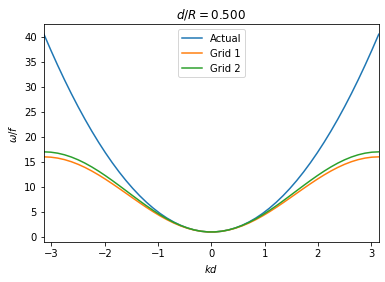

In [19]:
import importlib
importlib.reload(accuracy2d)

accuracy2d.main(0.5)

Both graphically and analytically, Grid 2 provides a more accurate numerical solution than Grid 1. The accuracy is measured here in terms of proximity to the actual dispersion relation. Let's consider the 3 relations where the index respectively indicates "Grid 1", "Grid 2", "actual", and $x=kd$:

$$\omega_1 ^2 = f^2 \cos^2(\frac{x}{2}) + \frac{4gH \sin^2(\frac{x}{2})}{d^2} = \omega_2 ^2 - f^2 \sin^2(\frac{x}{2})$$
$$\omega_2 ^2 = f^2 + \frac{4gH \sin^2(\frac{x}{2})}{d^2}$$
$$\omega_a^2 = f^2 + gH k^2$$

So for $x \rightarrow 0$, using $\sin^2(\frac{x}{2}) = \frac{x^2}{4} - \frac{x^4}{48} + o(x^4)$, we get the following: $\omega_2 ^2 = \omega_a ^2 - \frac{gH}{12d^2} x^4 + o(x^4)$ while $\omega_1 ^2 = \omega_a ^2 - \frac{f}{4} x^2 + o(x^2)$.

So mathematically, Grid 2 is more accurate than Grid 1 because $\omega_2$ is closer to $\omega_a$ by 2 orders for small values of kd. 

Physically, u and v are one: the components of the same velocity vector. Therefore, since the problem is 1D, they should be applied to the same grid. Otherwise at best we are less accurate, at worst we might generate undesired local momentums (if the two components of the velocity are staggered). So it is not surprising that Grid 2 would be more accurate.

Note: if the problem was 2D or 3D (spatially, i.e. varying "y"), momentums could be part of the physics and having 3 different staggered grids would / could be admissible. To be accurate they would still very likely need to be staggered from the "h grid", as well as staggered from one another (in their respective dimensions). 

## Problem 5

#### Equations
The 3 equations for the problem "no variation in y", discretized on a staggered grid following the example of the drop in the pond displayed in the lab, but using the most accurate grid, i.e. where both components of the velocity are on the same staggered grid, read as follows:

(1)
$$\frac {u_{i}(t+dt)-u_{i}(t-dt)}{2 dt} + g \frac {h_{i + 1}(t) - h_{i}(t)}{dx} - f v_{i}(t) = 0$$
(2)
$$\frac {v_{i}(t+dt)-v_{i}(t-dt)}{2 dt} + f u_{i}(t) = 0$$
(3)
$$\frac {h_{i}(t+dt)-h_{i}(t-dt)}{2 dt} + H \frac {u_{i}(t) - u_{i - 1}(t)}{dx} = 0$$



#### Initial conditions

First, let the midpoint m=N/2. Using the forward Euler Scheme for the Predictor-Corrector to start, the above equations become:

$$\frac {u(t+dt, x)-u(t, x)}{dt} + g \frac {h(t, x+dx) - h(t, x)}{dx} - f v(t,x) = 0$$
$$\frac {v(t+dt, x)-v(t, x)}{dt} + f u(t,x) = 0$$
$$\frac {h(t+dt, x)-h(t, x)}{dt} + H \frac {u(t, x) - u(t, x-dx)}{dx} = 0$$

###### Therefore, at t=0:

$\forall i, h_{i}(0) = 0$ except $h_{m}(0) = h_{0}$

$\forall i, u_{i}(0) = 0, v_{i}(0) = 0$

###### And at t=dt:

$\forall i, u_{i}(dt)=0$ except for $u_{m-1}(dt) = - h_{0} g \frac{dt}{dx}$ and $u_{m}(dt) = - u_{m-1}(dt)$

$\forall i, v_{i}(dt) = 0 $

$h_{m}(dt) = h_{m}(0) = h_{0}$



#### Boundary conditions
This time we assume there is a wall at $u_{1}$ and $u_{N}$, so we will ignore the value of $h_{1}$. Values of v cn be set to zero along the wall, since we don't care for y axis movements. So:

$u_{1}(t) = 0$

$u_{N}(t) = 0$

$v_{1}(t) = 0$

$v_{N}(t) = 0$

$h_{1}(t) = h_{2}(t)$

$h_{N}(t) = h_{N-1}(t)$


#### [modified rain.py function] No y variation with coriolis, staggered grid combining u,v VS h, leapfrog shceme. 

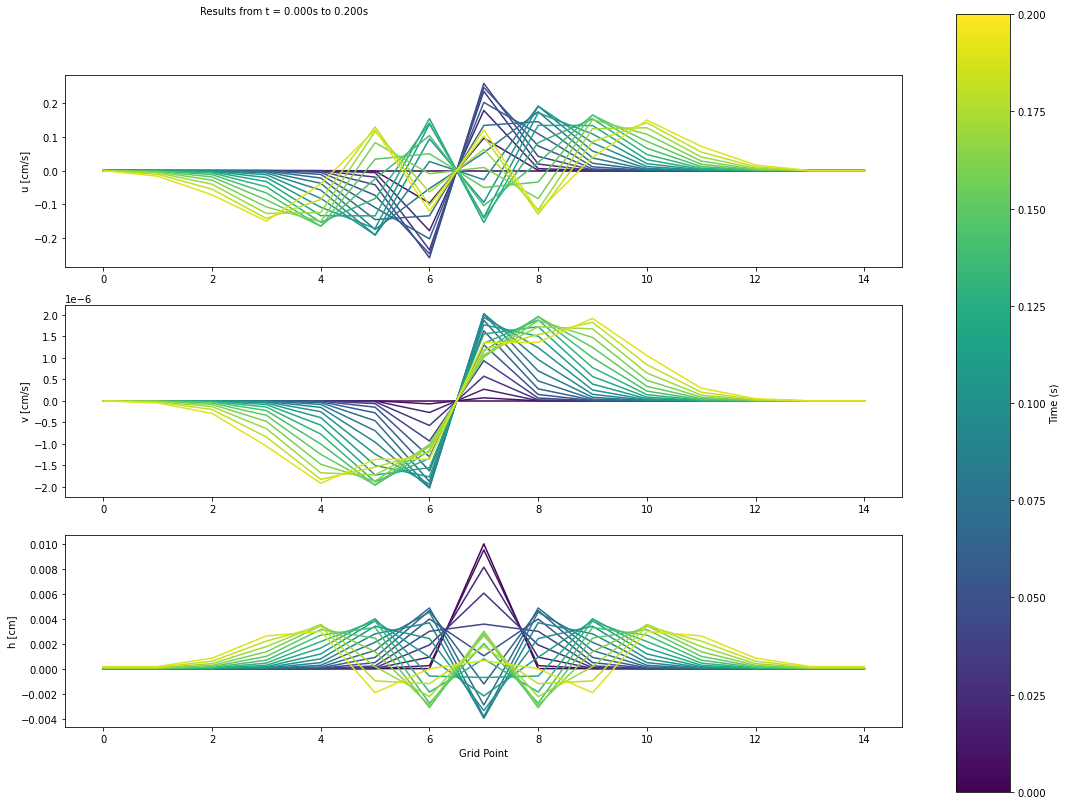

In [21]:
import importlib
importlib.reload(rainlab)

rainlab.rain([200, 15])

#### [original function] No coriolis (no v), staggered grid combining, leapfrog shceme. 

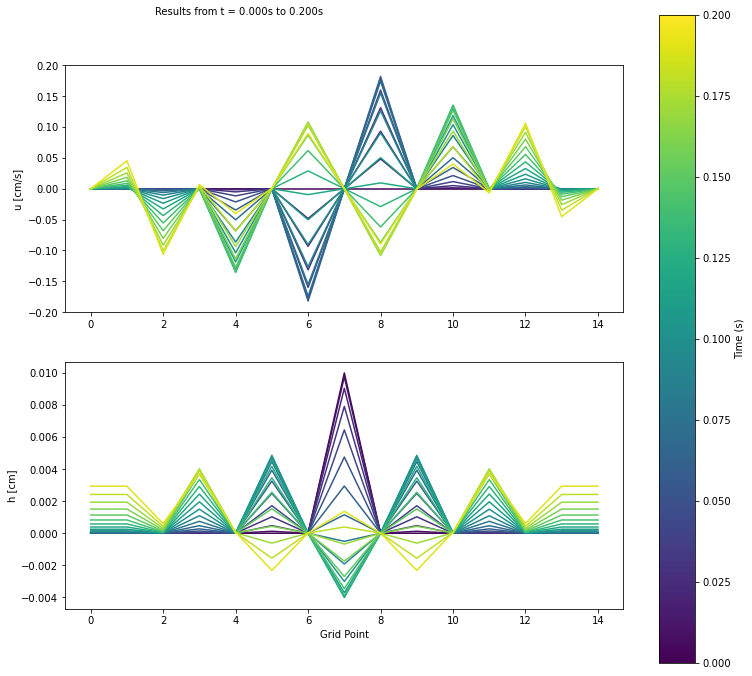

In [16]:
rain.rain([200, 15])